# Análisis de Datos y Feature Engineering en Series Temporales de Sensores

En este notebook se realiza un análisis exploratorio y transformaciones avanzadas sobre datos de sensores geotécnicos. Cada paso incluye una visualización para interpretar los resultados y las nuevas variables generadas.

In [5]:
!pip install statsmodels seaborn --quiet

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Cargar datos
ruta = '../data/df_ancon.csv'
df = pd.read_csv(ruta, index_col=0)
df.index = pd.to_datetime(df.index)

df

,sh1,p,C1,B1,Tem_1,DE1
2019-05-03,NaN,0.000,NaN,NaN,NaN,0.000000
2019-05-04,NaN,0.000,NaN,NaN,NaN,0.000000
2019-05-05,NaN,0.000,NaN,NaN,NaN,0.000000
2019-05-06,NaN,0.000,NaN,NaN,NaN,0.000000
2019-05-07,NaN,0.000,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...
2021-07-04,NaN,0.000,2.433760,-1.690799,26.590017,1.107410
2021-07-05,NaN,0.762,2.453399,-1.689042,26.594302,0.000000
2021-07-06,NaN,0.000,2.487892,-1.703556,27.582069,0.000000
2021-07-07,NaN,0.000,2.527490,-1.704490,28.895240,0.369137


## 1. Visualización básica

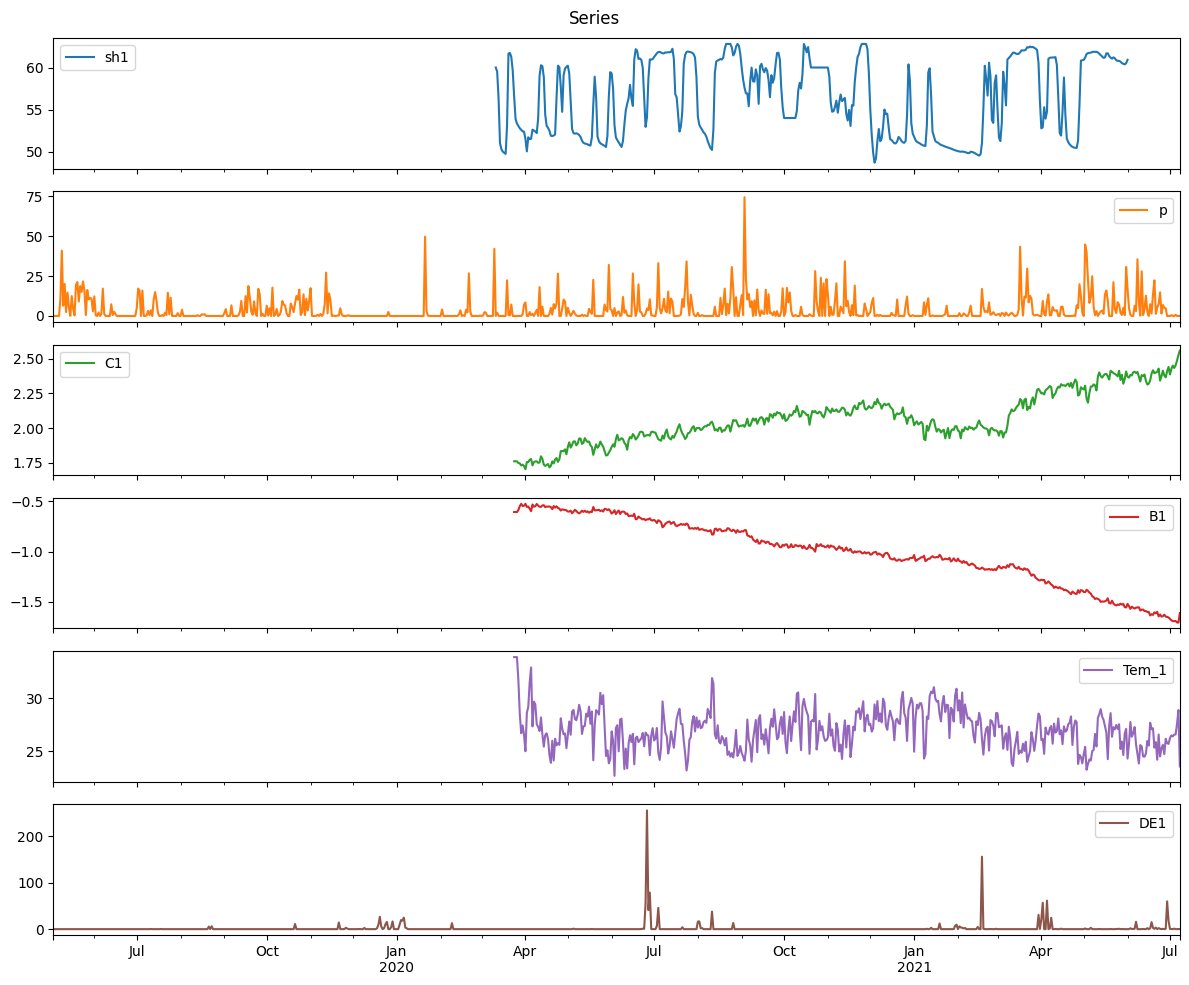

In [9]:
# Visualización de las series
df.plot(subplots=True, figsize=(12,10), title='Series')
plt.tight_layout()
plt.show()

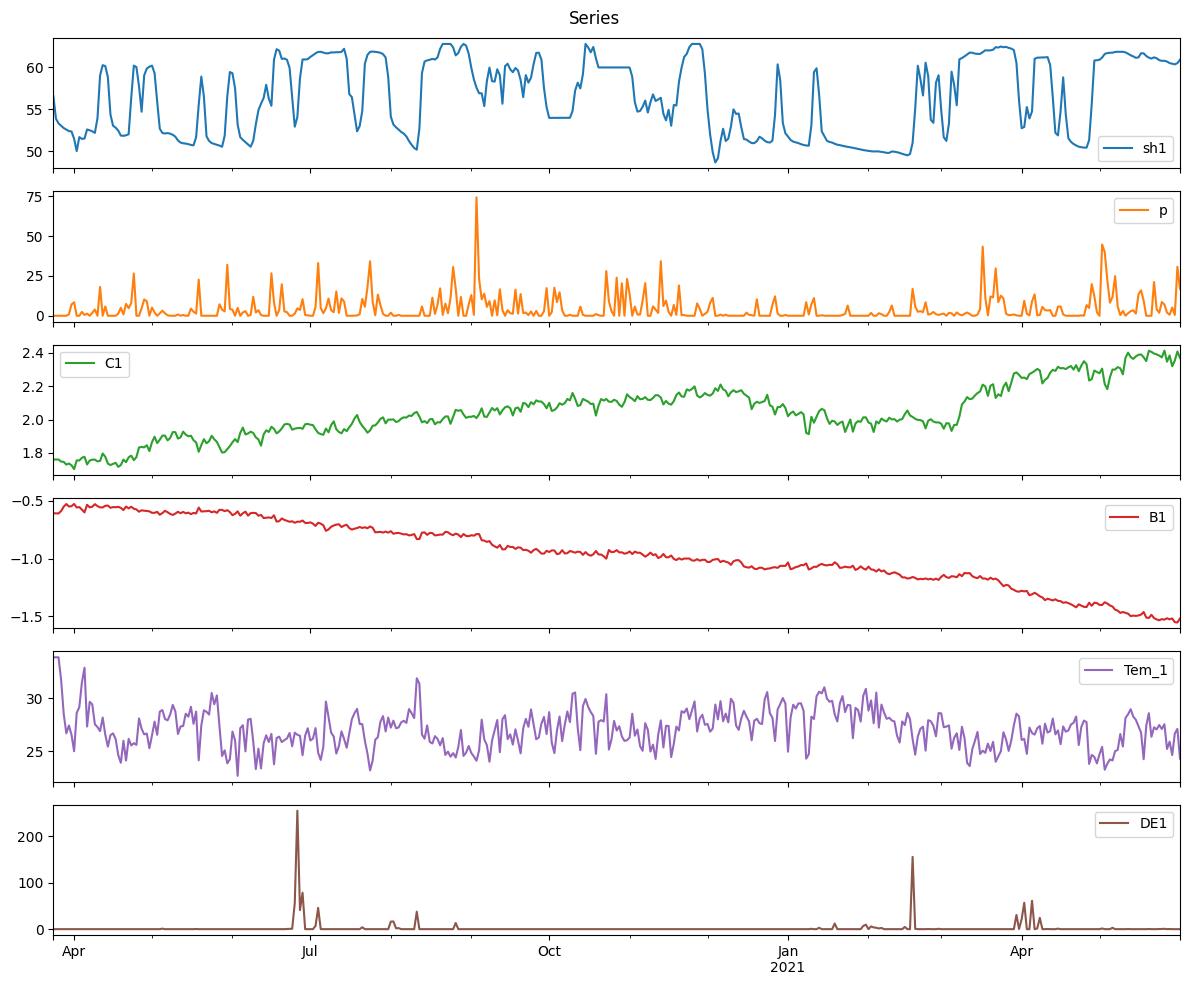

In [10]:
df = df.dropna()
df.plot(subplots=True, figsize=(12,10), title='Series')
plt.tight_layout()
plt.show()

## 2. Interpolación y llenado de valores nulos

In [17]:
# Interpolación lineal y llenado con la media
print("Valores nulos restantes por columna:")
print(df.isnull().sum())

for col in df.columns:
    df.loc[:, col] = df[col].interpolate(method='linear')
    df.loc[:, col] = df[col].fillna(df[col].mean())

print("Valores nulos restantes por columna:")
print(df.isnull().sum())

Valores nulos restantes por columna:
sh1      0
p        0
C1       0
B1       0
Tem_1    0
DE1      0
dtype: int64
Valores nulos restantes por columna:
sh1      0
p        0
C1       0
B1       0
Tem_1    0
DE1      0
dtype: int64


## 3. Identificación de valores atípicos (outliers) por Z-Score

El Z-Score es una medida estadística que indica cuántas desviaciones estándar se encuentra un valor respecto a la media de la variable.
Un Z-Score cercano a 0 indica que el valor está cerca de la media, mientras que valores mayores en valor absoluto (por ejemplo, >2 o <-2)
sugieren que el dato es atípico o un posible outlier.

Interpretación:
- |Z-Score| < 2: El dato es considerado normal dentro de la distribución.
- |Z-Score| > 2: El dato puede considerarse atípico (outlier moderado).
- |Z-Score| > 3: El dato es un outlier extremo.

Cantidad de outliers por variable:
sh1           0
p            21
C1           22
B1           13
Tem_1        15
DE1           9
outlier_p    46
dtype: int64


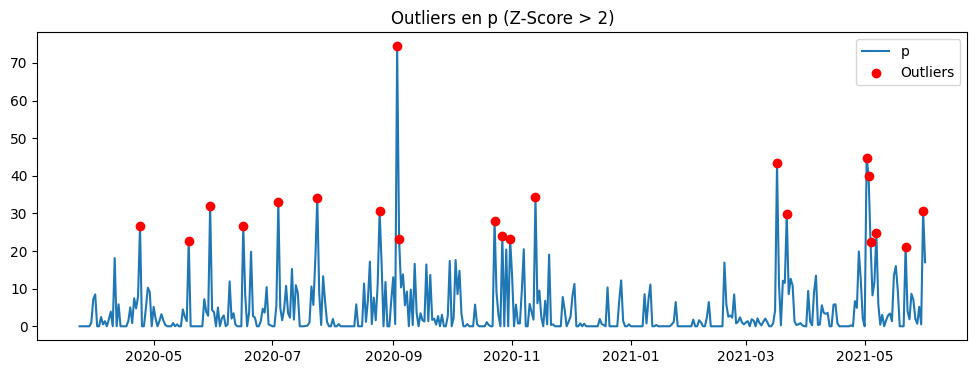

In [23]:
# Cálculo de Z-Score y detección de outliers
z_scores = df.apply(zscore)
outliers = (np.abs(z_scores) > 2)
print("Cantidad de outliers por variable:")
print(outliers.sum())

# Visualización de outliers en p
df.loc[:, 'outlier_p'] = outliers['p']
plt.figure(figsize=(12,4))
plt.plot(df['p'], label='p')
plt.scatter(df.index[df['outlier_p']], df['p'][df['outlier_p']], color='red', label='Outliers', zorder=5)
plt.title('Outliers en p (Z-Score > 2)')
plt.legend()
plt.show()

## 4. Cálculo de acumulados y acumulados móviles

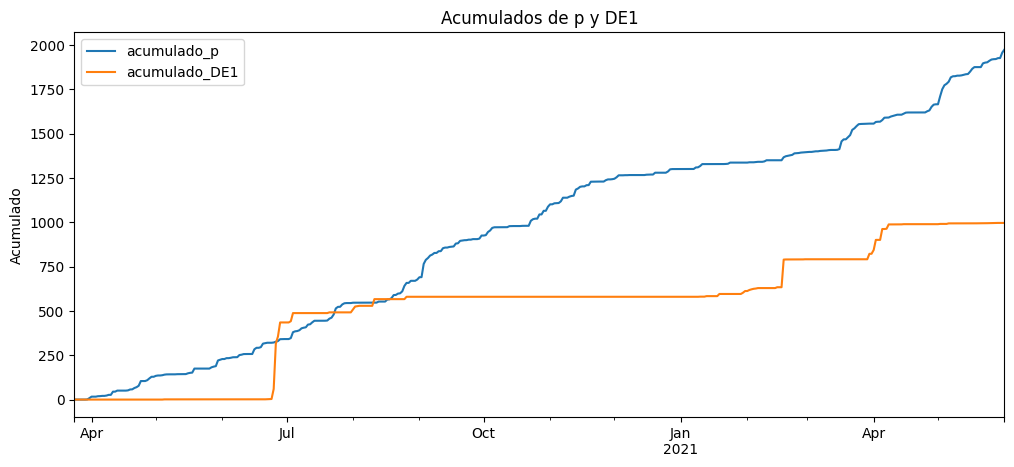

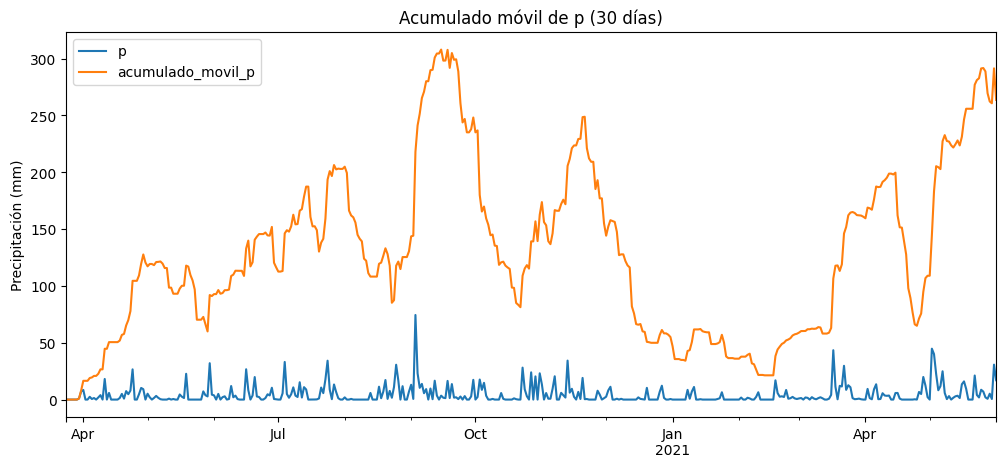

In [26]:
# Acumulados totales
df.loc[:, 'acumulado_p'] = df['p'].cumsum()
df.loc[:, 'acumulado_DE1'] = df['DE1'].cumsum()

# Acumulados móviles (ventana de 30 días)
df.loc[:, 'acumulado_movil_p'] = df['p'].rolling(window=30, min_periods=1).sum()

# Visualización de acumulados
df[['acumulado_p', 'acumulado_DE1']].plot(figsize=(12,5))
plt.title('Acumulados de p y DE1')
plt.ylabel('Acumulado')
plt.show()

# Visualización de acumulado móvil
df[['p', 'acumulado_movil_p']].plot(figsize=(12,5))
plt.title('Acumulado móvil de p (30 días)')
plt.ylabel('Precipitación (mm)')
plt.show()

## 5. Cálculo de tasas de cambio en C1 y B1

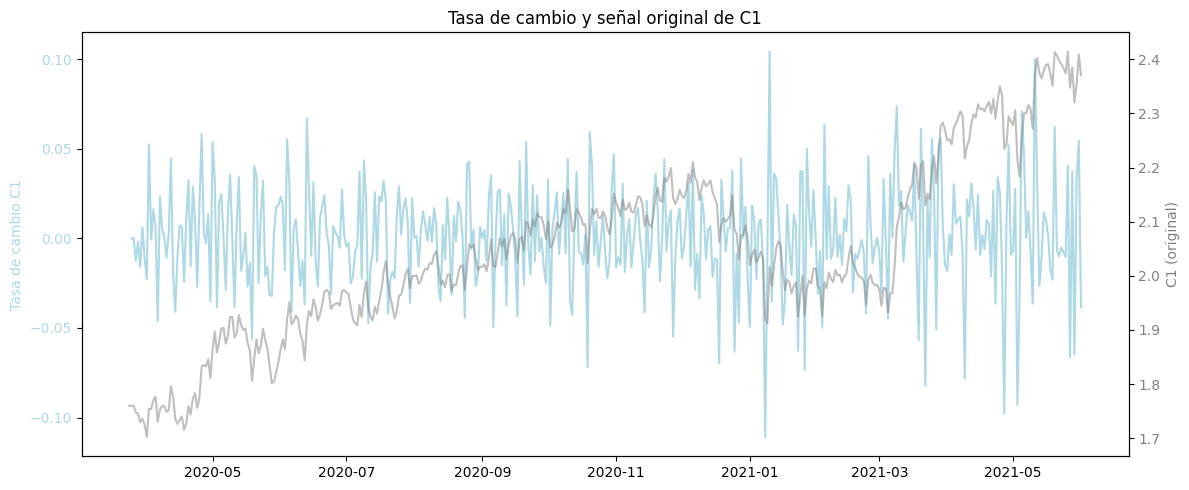

In [32]:
df.loc[:, 'tasa_C1'] = df['C1'].diff()
df.loc[:, 'tasa_B1'] = df['B1'].diff()

# Visualización de tasas de cambio y señal original en eje twin
fig, ax1 = plt.subplots(figsize=(12,5))
color = 'lightblue'
ax1.plot(df.index, df['tasa_C1'], label='Tasa de cambio C1', color=color)
ax1.set_ylabel('Tasa de cambio C1', color=color)
ax1.set_title('Tasa de cambio y señal original de C1')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'gray'
ax2.plot(df.index, df['C1'], label='C1 (original)', color=color, alpha=0.5)
ax2.set_ylabel('C1 (original)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

## 6. Descomposición de series temporales y extracción de tendencia y residuos

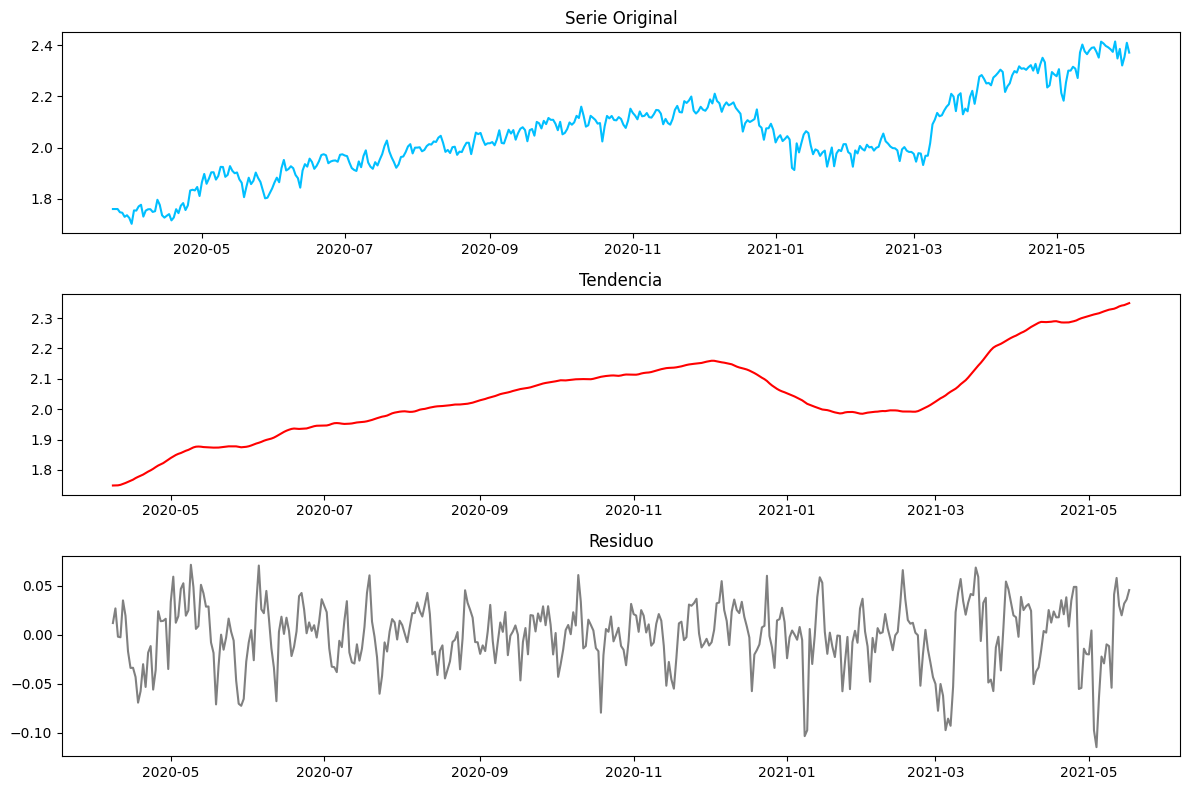

In [34]:
# Descomposición aditiva para C1
descomposicion = seasonal_decompose(df['C1'], model='additive', period=30)
df.loc[:, 'C1_tendencia'] = descomposicion.trend
df.loc[:, 'C1_residuo'] = descomposicion.resid

# Visualización de la descomposición
fig, axs = plt.subplots(3, 1, figsize=(12, 8))
axs[0].plot(df['C1'], label='Original', color='deepskyblue')
axs[0].set_title('Serie Original')
axs[1].plot(df['C1_tendencia'], label='Tendencia', color='red')
axs[1].set_title('Tendencia')
axs[2].plot(df['C1_residuo'], label='Residuo', color='gray')
axs[2].set_title('Residuo')
plt.tight_layout()
plt.show()

## 7. Anomalías en residuos (Z-Score)

Cantidad de anomalías en residuos de C1: 5


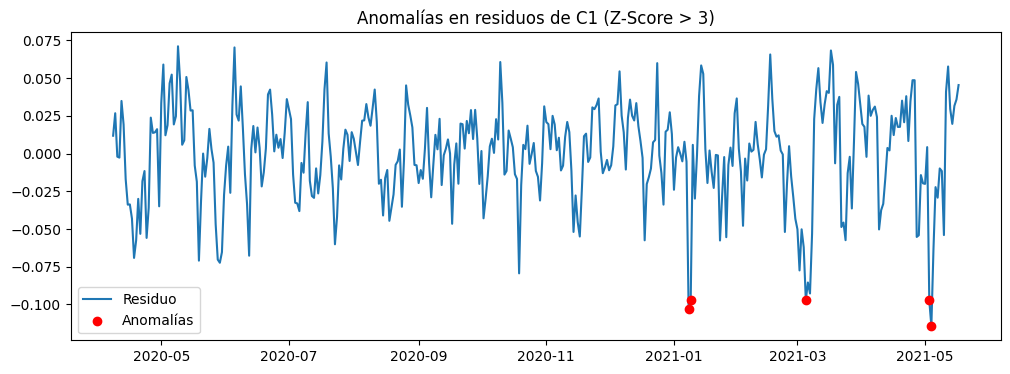

In [35]:
resid_z = zscore(df['C1_residuo'].dropna())
anomalias_resid = np.abs(resid_z) > 3
print(f"Cantidad de anomalías en residuos de C1: {anomalias_resid.sum()}")

# Visualización de anomalías en residuos
plt.figure(figsize=(12,4))
plt.plot(df['C1_residuo'], label='Residuo')
plt.scatter(df['C1_residuo'].dropna().index[anomalias_resid], df['C1_residuo'].dropna()[anomalias_resid], color='red', label='Anomalías', zorder=5)
plt.title('Anomalías en residuos de C1 (Z-Score > 3)')
plt.legend()
plt.show()

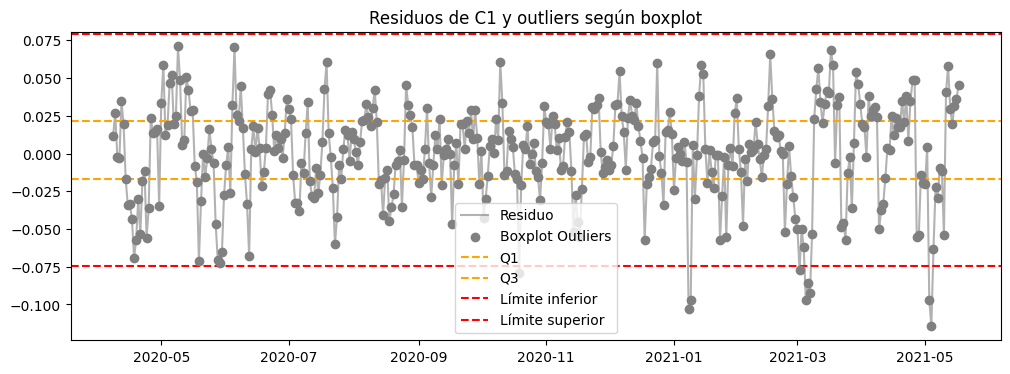

Límite inferior: -0.075, Límite superior: 0.079
Cantidad de outliers bajos: 9
Cantidad de outliers altos: 0


In [40]:
# Análisis de outliers en residuos usando límites de boxplot
residuos = df['C1_residuo'].dropna()
q1 = residuos.quantile(0.25)
q3 = residuos.quantile(0.75)
iqr = q3 - q1
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr


plt.figure(figsize=(12,4))
plt.plot(residuos.index, residuos.values, label='Residuo', color='gray', alpha=0.6)
plt.scatter(residuos.index, residuos.values, c='gray', label='Boxplot Outliers', zorder=5)
plt.axhline(q1, color='orange', linestyle='--', label='Q1')
plt.axhline(q3, color='orange', linestyle='--', label='Q3')
plt.axhline(limite_inferior, color='red', linestyle='--', label='Límite inferior')
plt.axhline(limite_superior, color='red', linestyle='--', label='Límite superior')
plt.title('Residuos de C1 y outliers según boxplot')
plt.legend()
plt.show()

print(f"Límite inferior: {limite_inferior:.3f}, Límite superior: {limite_superior:.3f}")
print(f"Cantidad de outliers bajos: {(residuos < limite_inferior).sum()}")
print(f"Cantidad de outliers altos: {(residuos > limite_superior).sum()}")


## 8. Correlaciones y correlaciones rezagadas

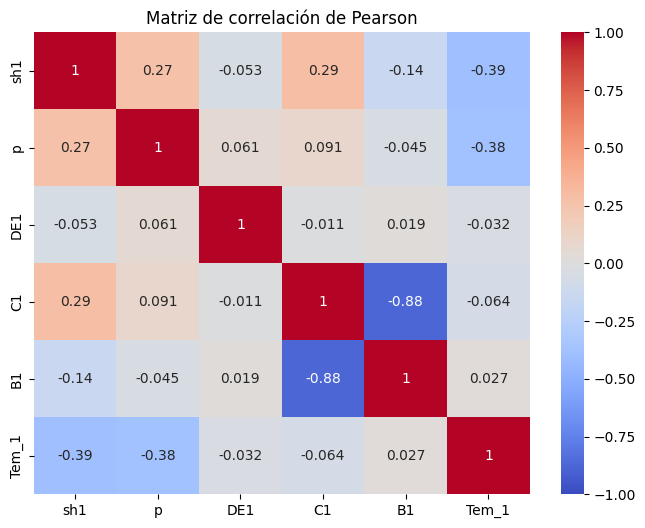

In [43]:
# Correlación de Pearson entre variables principales
df_corr = df[['sh1', 'p', 'DE1', 'C1', 'B1', 'Tem_1']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de correlación de Pearson')
plt.show()

Máxima correlación: 0.319 en lag = 1 días
Interpretación: la precipitación (p) precede a sh1 por 1 días.


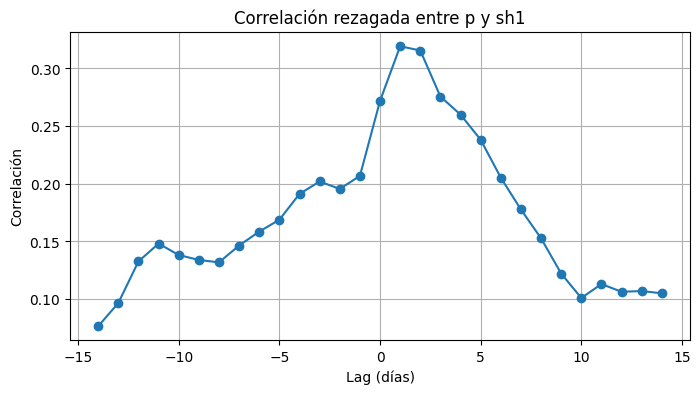

In [47]:
# Correlación rezagada entre p y sh1 (lag de -14 a +14 días)
lags = range(-14, 15)
corrs = [df['sh1'].corr(df['p'].shift(lag)) for lag in lags]

# Identificar el lag de máxima correlación
max_idx = np.argmax(np.abs(corrs))
max_lag = lags[max_idx]
max_corr = corrs[max_idx]
print(f"Máxima correlación: {max_corr:.3f} en lag = {max_lag} días")

# Interpretación
if max_lag > 0:
    print(f"Interpretación: la precipitación (p) precede a sh1 por {max_lag} días.")
elif max_lag < 0:
    print(f"Interpretación: sh1 precede a la precipitación (p) por {abs(max_lag)} días.")
else:
    print("Interpretación: la máxima correlación ocurre sin desfase temporal (lag=0).")

plt.figure(figsize=(8,4))
plt.plot(lags, corrs, marker='o')
plt.title('Correlación rezagada entre p y sh1')
plt.xlabel('Lag (días)')
plt.ylabel('Correlación')
plt.grid()
plt.show()

## Ejercicios propuestos

1. **Remuestreo de series temporales:**
   - Remuestrea todas las series a diferentes frecuencias: diaria, semanal, quincenal y mensual. Analiza cómo cambian las características estadísticas y visualizaciones en cada escala temporal.

2. **Detección de anomalías en múltiples escalas:**
   - Para cada escala de remuestreo, identifica anomalías en todas las series utilizando:
     - Z-Score (por ejemplo, |z| > 2 y |z| > 3)
     - Método de Tukey (usando los límites del boxplot)
   - Compara la cantidad y tipo de anomalías detectadas en cada escala y discute posibles causas.

3. **Descomposición y tendencias:**
   - Descompón cada serie en sus componentes de tendencia, estacionalidad y residuo para cada escala de remuestreo.
   - Compara las tendencias obtenidas entre las diferentes series y escalas. ¿Qué similitudes o diferencias encuentras, especialmente en los periodos donde se detectaron anomalías?

4. **Correlación rezagada y periodos de interés:**
   - Calcula la correlación rezagada entre pares de series (por ejemplo, precipitación y desplazamiento, temperatura y desplazamiento) en cada escala de remuestreo.
   - Identifica los lags (desfases) donde la correlación es máxima y discute posibles relaciones de causa-efecto o periodos de interés para el monitoreo.

5. **Comparación de métodos de detección de outliers:**
   - Elige una serie y una escala temporal, y compara los outliers detectados por Z-Score y por Tukey. ¿Coinciden? ¿En qué casos difieren y por qué podría suceder esto?

## Conclusiones

- El remuestreo a diferentes escalas temporales permite observar patrones y anomalías que pueden pasar desapercibidos en la escala original.
- La detección de outliers y anomalías es sensible a la escala temporal y al método utilizado, por lo que es recomendable comparar varios enfoques.
- La descomposición de series y el análisis de tendencias ayudan a entender la evolución de los procesos monitoreados y a identificar periodos críticos.
- El análisis de correlación rezagada es clave para descubrir relaciones de influencia y anticipar eventos relevantes en ingeniería geotécnica.

## Recursos adicionales

- [Pandas: Resampling and Frequency Conversion](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)
- [Boxplot Outlier Detection (Wikipedia)](https://en.wikipedia.org/wiki/Box_plot#Outliers)
- [Statsmodels Seasonal Decompose](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)